In [1]:
pip install torch torchvision matplotlib scikit-learn

# Treinamento

100%|██████████| 170M/170M [00:03<00:00, 49.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/20], Loss: 1.3745, Val Loss: 1.1060, Accuracy: 0.5046, Val Accuracy: 0.6095, F1 Score: 0.6065
Epoch [2/20], Loss: 0.9951, Val Loss: 0.9340, Accuracy: 0.6453, Val Accuracy: 0.6678, F1 Score: 0.6653
Epoch [3/20], Loss: 0.8262, Val Loss: 0.8768, Accuracy: 0.7084, Val Accuracy: 0.6903, F1 Score: 0.6883
Epoch [4/20], Loss: 0.7007, Val Loss: 0.8967, Accuracy: 0.7519, Val Accuracy: 0.6910, F1 Score: 0.6907
Epoch [5/20], Loss: 0.5965, Val Loss: 0.8624, Accuracy: 0.7883, Val Accuracy: 0.7107, F1 Score: 0.7130
Epoch [6/20], Loss: 0.4981, Val Loss: 0.8917, Accuracy: 0.8257, Val Accuracy: 0.7102, F1 Score: 0.7061
Epoch [7/20], Loss: 0.4092, Val Loss: 1.0067, Accuracy: 0.8547, Val Accuracy: 0.7007, F1 Score: 0.6997
Epoch [8/20], Loss: 0.3298, Val Loss: 1.0233, Accuracy: 0.8844, Val Accuracy: 0.7038, F1 Score: 0.7046
Epoch [9/20], Loss: 0.2671, Val Loss: 1.1176, Accuracy: 0.9065, Val Accuracy: 0.7001, F1 Score: 0.6993
Epoch [10/20], Loss: 0

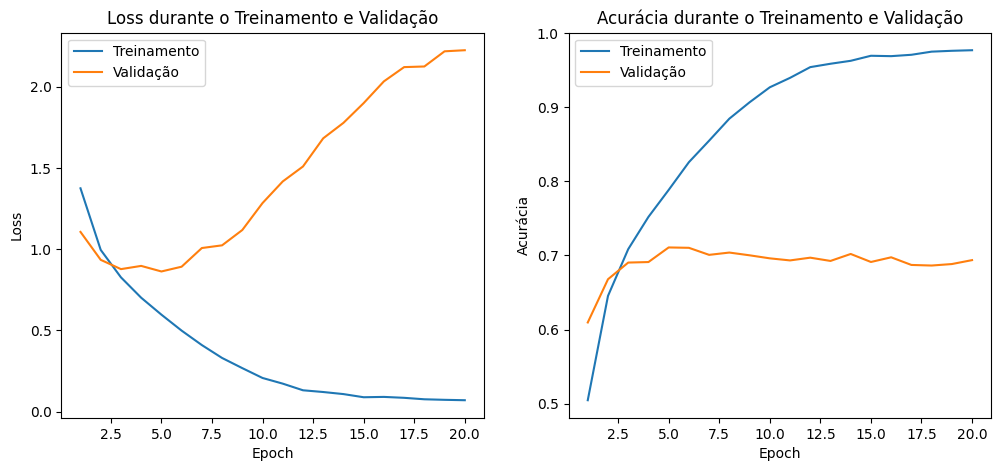

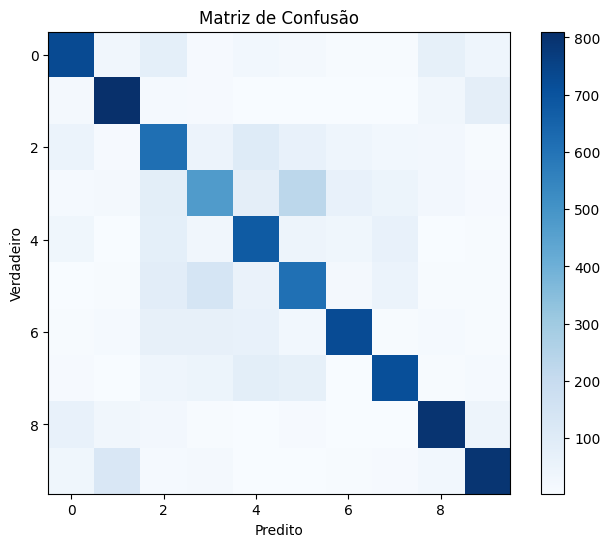

In [2]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Definindo configurações gerais
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
learning_rate = 0.001
num_epochs = 20

# 1. Carregar e Pré-processar o Dataset
# Escolha o dataset desejado (ex: CIFAR10, MNIST ou outro dataset disponível)
# Exemplo: CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 2. Definindo o Modelo
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

# 3. Funções de Treinamento e Validação
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(model, loader):
    model.train()
    running_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return running_loss / len(loader), acc, f1

def validate(model, loader):
    model.eval()
    running_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return running_loss / len(loader), acc, f1, all_labels, all_preds

# 4. Loop de Treinamento
best_acc = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train(model, train_loader)
    val_loss, val_acc, val_f1, val_labels, val_preds = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# 5. Gráficos de Desempenho
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Treinamento")
plt.plot(epochs, val_losses, label="Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss durante o Treinamento e Validação")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Treinamento")
plt.plot(epochs, val_accuracies, label="Validação")
plt.xlabel("Epoch")
plt.ylabel("Acurácia")
plt.legend()
plt.title("Acurácia durante o Treinamento e Validação")
plt.show()

# 6. Matriz de Confusão
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


# Predicao

Files already downloaded and verified


<ipython-input-3-e8123dc83be8>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Acurácia no conjunto de teste: 0.6990
F1 Score no conjunto de teste: 0.7015


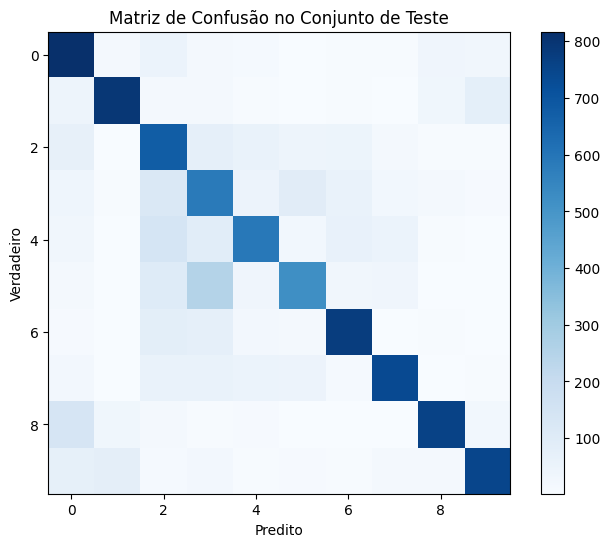

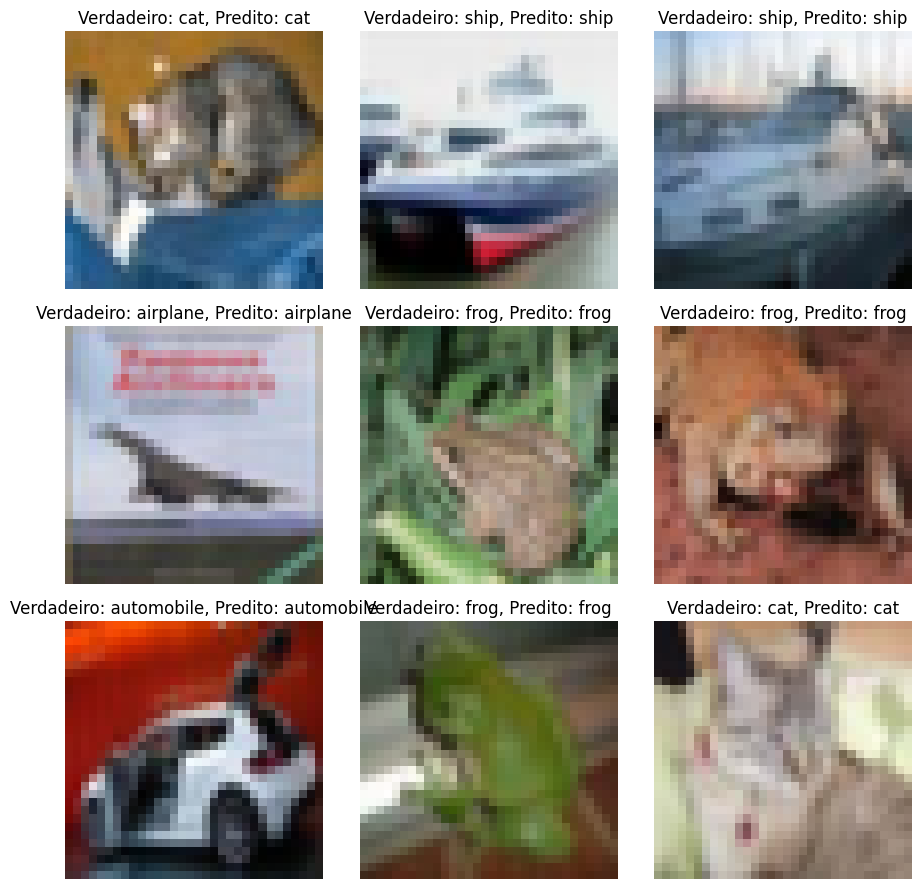

In [3]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Definindo o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Carregar o Dataset de Teste e Pré-processar
# Usando as mesmas transformações que no treinamento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Carregar o dataset de teste (exemplo: CIFAR10)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Definindo o Modelo (mesma arquitetura do modelo treinado)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

# 3. Carregar os Pesos Treinados
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 4. Função para Fazer Predições
def predict(model, loader):
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

# 5. Avaliar o Desempenho do Modelo
test_labels, test_preds = predict(model, test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")
print(f"F1 Score no conjunto de teste: {test_f1:.4f}")

# 6. Matriz de Confusão
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Matriz de Confusão no Conjunto de Teste")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

# 7. Visualização de algumas predições
classes = test_dataset.classes
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i in range(9):
    img, label = test_dataset[i]
    img = img / 2 + 0.5  # Desnormalizar a imagem
    npimg = img.numpy()
    pred = test_preds[i]

    axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[i].set_title(f"Verdadeiro: {classes[label]}, Predito: {classes[pred]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
